In [ ]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=ce7adec31f63d1922f79821b870a796265f5401321601dee8e260acfff81dcba
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
df = pd.read_csv('https://samatrix-data.s3.ap-south-1.amazonaws.com/Statistics-Project/veteran.csv')
df_event= df[df['Y'] ==1]


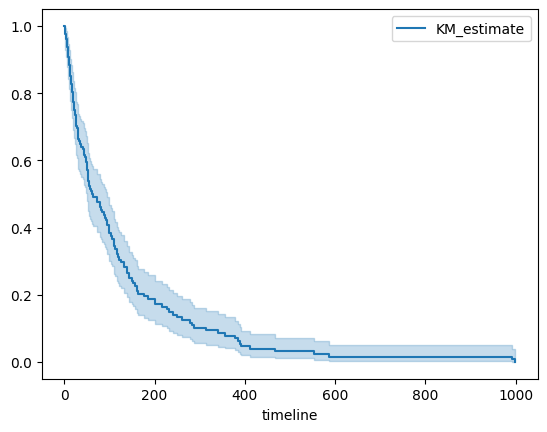

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df_event['TIME'], event_observed = df_event['Y'])
kmf.plot_survival_function()
plt.title('')
plt.show()

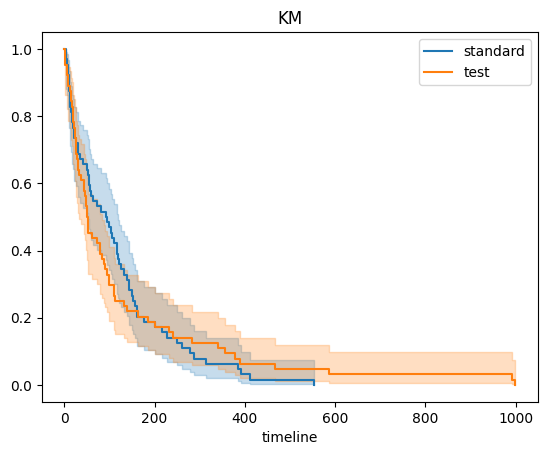

In [ ]:
for trt_group in df_event['trt'].unique():
    mask = df_event['trt'] == trt_group

    kmf.fit(df_event[mask]['TIME'], df_event[mask]['Y'], label = str(trt_group))
    kmf.plot_survival_function()

plt.title("KM")
plt.show()

In [ ]:
#median survival time
for trt_group in df_event['trt'].unique():
    mask = df_event['trt'] == trt_group
    kmf.fit(df_event[mask]['TIME'], df_event[mask]['Y'], label=str(trt_group))
    print(f"median survival for treatement {trt_group}: {kmf.median_survival_time_}")

median survival for treatement standard: 95.0
median survival for treatement test: 52.0


In [ ]:
from lifelines.statistics import logrank_test
group1=df_event[df_event['trt']== r'standard']
group2=df_event[df_event['trt']== 'test']

results= logrank_test(group1['TIME'],group2['TIME'],event_observed_A=group1['Y'], event_observed_B=group2['Y'])
print(results.summary)
print(results.summary)

   test_statistic        p  -log2(p)
0          0.0116  0.91423  0.129371
   test_statistic        p  -log2(p)
0          0.0116  0.91423  0.129371


In [ ]:
#coxPH test
from lifelines import CoxPHFitter
df_wide=df_event.copy()

#encoding
df_wide = pd.get_dummies(df_wide,columns=['trt','celltype','priortherapy'],drop_first=True)

#cophx model
cph = CoxPHFitter()
cph.fit(df_wide, duration_col='TIME', event_col='Y')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 128 total observations, 0 right-censored observations>
             duration col = 'TIME'
                event col = 'Y'
      baseline estimation = breslow
   number of observations = 128
number of events observed = 128
   partial log-likelihood = -465.21
         time fit was run = 2025-05-30 05:07:49 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
ID                  0.00      1.00      0.01           -0.03            0.03                0.97                1.03
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.16      1.17      1.02           -1.84            2.16                0.16                8.63
celltype_large     -0.83      0.43      0.36           -1.53           -0.14                0.22                0.87
celltype_smallcell -0.12      0.88      0.38           -0.88            0.63                0.42                1.88
celltype_squamous  -0.97      0.38      0.66           -2.27            0.33                0.10                1.38
priortherapy_yes    0.18      1.20      0.24           -0.28            0.65                0.76                1.91

                    cmp to     z      p  -log2(p)
covariate                                        
ID                    0.00  0.20   0.84      0.25
karno                 0.00 -6.08 <0.005     29.60
diagtime              0.00 -0.47   0.63      0.66
age                   0.00 -1.54   0.12      3.02
trt_test              0.00  0.16   0.88      0.19
celltype_large        0.00 -2.34   0.02      5.71
celltype_smallcell    0.00 -0.32   0.75      0.42
celltype_squamous     0.00 -1.47   0.14      2.82
priortherapy_yes      0.00  0.79   0.43      1.21
---
Concordance = 0.74
Partial AIC = 948.43
log-likelihood ratio test = 62.38 on 9 df
-log2(p) of ll-ratio test = 31.00

In [ ]:
#time varying survival analysis
#step 1 separate rows
df_start=df[df["Y"]==0].copy()
df_event=df[df["Y"]==1].copy()

#merge $ change column name
df_event=df_event.rename(columns={"TIME":"stop","Y":"event"})
df_start=df_start.rename(columns={"TIME":"start"})

df_timevarying=pd.merge(df_start,df_event[["ID","stop","event"]],on="ID")

#one-hot encoding
df_timevarying=pd.get_dummies(df_timevarying,columns=['trt','celltype','priortherapy'],drop_first=True)

#FINAL coding
print(df_timevarying[['ID','start','stop','event']].head())

   ID  start  stop  event
0   1      0    72      1
1   2      0   411      1
2   3      0   228      1
3   4      0   126      1
4   5      0   118      1


Checking for NaN values in df_timevarying:
ID                    0
start                 0
karno                 0
diagtime              0
age                   0
stop                  0
event                 0
trt_test              0
celltype_large        0
celltype_smallcell    0
celltype_squamous     0
priortherapy_yes      0
dtype: int64

Checking for Inf values in df_timevarying:
ID                    0
start                 0
karno                 0
diagtime              0
age                   0
stop                  0
event                 0
trt_test              0
celltype_large        0
celltype_smallcell    0
celltype_squamous     0
priortherapy_yes      0
dtype: int64


<lifelines.CoxTimeVaryingFitter: fitted with 128 periods, 128 subjects, 128 events>
         event col = 'event'
         penalizer = 0.1
number of subjects = 128
 number of periods = 128
  number of events = 128
partial log-likelihood = -469.67
  time fit was run = 2025-05-30 05:13:15 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
karno              -0.03      0.97      0.01           -0.04           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
trt_test            0.30      1.35      0.19           -0.07            0.68                0.93                1.97
celltype_large     -0.59      0.55      0.26           -1.11           -0.07                0.33                0.93
celltype_smallcell -0.03      0.97      0.24           -0.50            0.44                0.60                1.56
celltype_squamous  -0.84      0.43      0.26           -1.35           -0.33                0.26                0.72
priortherapy_yes    0.10      1.10      0.21           -0.32            0.51                0.72                1.67

                    cmp to     z      p  -log2(p)
covariate                                        
karno                 0.00 -5.64 <0.005     25.81
diagtime              0.00 -0.26   0.80      0.33
age                   0.00 -1.11   0.27      1.91
trt_test              0.00  1.57   0.12      3.10
celltype_large        0.00 -2.24   0.03      5.31
celltype_smallcell    0.00 -0.12   0.90      0.14
celltype_squamous     0.00 -3.23 <0.005      9.65
priortherapy_yes      0.00  0.45   0.65      0.62
---
Partial AIC = 955.33
log-likelihood ratio test = 53.48 on 8 df
-log2(p) of ll-ratio test = 26.77

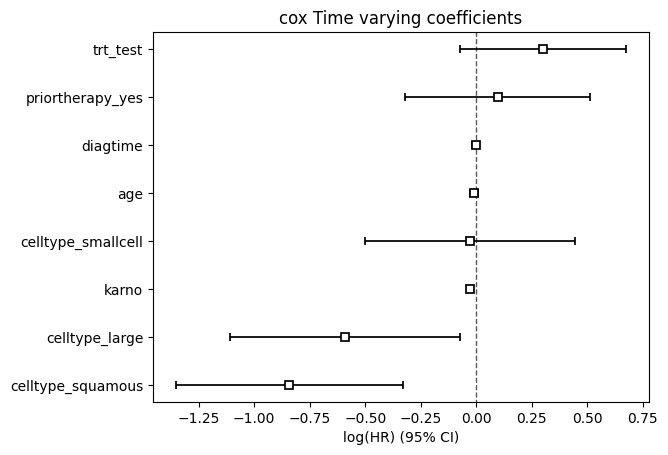

In [ ]:
##time timevarying cox model
from lifelines import CoxTimeVaryingFitter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#step 1 separate rows (re-run this part to ensure df_event and df_start are correct)
df_start=df[df["Y"]==0].copy()
df_event=df[df["Y"]==1].copy()

#merge $ change column name
df_event=df_event.rename(columns={"TIME":"stop","Y":"event"})
df_start=df_start.rename(columns={"TIME":"start"})

df_timevarying=pd.merge(df_start,df_event[["ID","stop","event"]],on="ID")

#one-hot encoding
df_timevarying=pd.get_dummies(df_timevarying,columns=['trt','celltype','priortherapy'],drop_first=True)
df_timevarying = df_timevarying.drop(columns=['Y', 'TIME'], errors='ignore')

print("Checking for NaN values in df_timevarying:")
print(df_timevarying.isnull().sum())

print("\nChecking for Inf values in df_timevarying:")
print(df_timevarying.isin([np.inf, -np.inf]).sum())

# Identify columns with NaNs or Infs
nan_cols = df_timevarying.columns[df_timevarying.isnull().any()].tolist()
inf_cols = df_timevarying.columns[df_timevarying.isin([np.inf, -np.inf]).any()].tolist()

if nan_cols:
    print(f"\nColumns with NaNs: {nan_cols}. Consider dropping or imputing these rows/columns.")

if inf_cols:
    print(f"\nColumns with Infs: {inf_cols}. Consider transforming or removing these rows/columns.")

ctv = CoxTimeVaryingFitter(penalizer=0.1)

try:
    ctv.fit(df_timevarying, id_col='ID', event_col='event', start_col='start', stop_col='stop')
    ctv.print_summary()
    ctv.plot()
    plt.title("cox Time varying coefficients")
    plt.show()

except ConvergenceError as e:
    print(f"Convergence Error: {e}")
    print("\nModel did not converge. Consider:")
    print("- Checking the data for extreme values, NaNs, or Infs.")
    print("- Increasing the penalizer value (e.g., to 0.1, 1.0) or trying elastic net (l1_ratio).")
    print("- Checking for high correlation among predictor variables.")
    print("- Reducing the number of predictors.")